### Standard CNN LSTM - Exp 7
With 3 time steps (For daily forecasting to capture short term patterns)

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Input, Flatten, TimeDistributed
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import shap
import lime
from IPython.display import HTML, display
import lime.lime_tabular

/Users/amalshar/miniforge3/envs/dlenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Enable eager execution
tf.compat.v1.enable_eager_execution()

In [3]:

# Load preprocessed dataset
df = pd.read_csv('/Users/amalshar/Desktop/USD/Spring 2025/Artificial Intelligence/AI Project/data/energy_weather_preprocessed.csv')

In [4]:
# Define features and target variable
FEATURES = ['current', 'voltage', 'reactive_power', 'apparent_power', 
            'temp', 'feels_like', 'temp_min', 'temp_max', 'pressure', 'humidity', 'speed',
            'temp_humidity_interaction', 'hour', 'day', 'month', 'year',
            'active_power_lag_1', 'active_power_lag_2', 'active_power_lag_3',
            'active_power_rolling_mean', 'active_power_rolling_std']

TARGET = 'active_power'

In [5]:
# Extract feature and target values
X = df[FEATURES].values
y = df[TARGET].values.reshape(-1, 1)  # Reshape for scaler and LSTM

In [6]:
# Apply MinMax Scaling
scaler_x = MinMaxScaler()
X_scaled = scaler_x.fit_transform(X)

scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(y)

In [7]:
# Define time steps for CNN-LSTM input
time_steps = 3
features = X_scaled.shape[1]

In [8]:
# Prepare sequential data for CNN-LSTM
X_seq = np.array([X_scaled[i-time_steps:i] for i in range(time_steps, len(X_scaled))])
y_seq = y_scaled[time_steps:]

In [9]:
# Split into train-validation-test sets
X_train, X_temp, y_train, y_temp = train_test_split(X_seq, y_seq, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [10]:
# Ensure correct reshaping for LSTM
X_train_reshaped = X_train.reshape((X_train.shape[0], time_steps, features))
X_val_reshaped = X_val.reshape((X_val.shape[0], time_steps, features))
X_test_reshaped = X_test.reshape((X_test.shape[0], time_steps, features))

In [11]:
# Define CNN-LSTM Model
model_cnn_lstm = Sequential([
    Input(shape=(time_steps, features)),  
    Conv1D(filters=64, kernel_size=2, activation='relu', padding='same'),  
    MaxPooling1D(pool_size=2),  
    TimeDistributed(Dense(64, activation='relu')),  # Preserve 3D shape before LSTM
    LSTM(64, activation='relu', return_sequences=True),  
    Dropout(0.2),
    LSTM(32, activation='relu'),  
    Dropout(0.2),
    Dense(16, activation='relu'),  
    Dense(1, activation='linear')  
])

In [12]:
# Compile model
model_cnn_lstm.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae', 'mape'])

In [13]:
# Early stopping and learning rate adjustment
early_stop = EarlyStopping(monitor='val_loss', patience=20, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=6, min_lr=1e-5)

In [14]:
# Train the model
history = model_cnn_lstm.fit(X_train_reshaped, y_train, epochs=100, batch_size=32, validation_data=(X_val_reshaped, y_val), 
                             callbacks=[early_stop, reduce_lr], verbose=1)

Epoch 1/100
13240/13240 ━━━━━━━━━━━━━━━━━━━━ 32s 2ms/step - loss: 0.0017 - mae: 0.0210 - mape: 46.7578 - val_loss: 0.0014 - val_mae: 0.0160 - val_mape: 33.3578 - learning_rate: 0.0010
Epoch 2/100
13240/13240 ━━━━━━━━━━━━━━━━━━━━ 29s 2ms/step - loss: 0.0014 - mae: 0.0166 - mape: 49.5124 - val_loss: 0.0015 - val_mae: 0.0247 - val_mape: 61.4650 - learning_rate: 0.0010
Epoch 3/100
13240/13240 ━━━━━━━━━━━━━━━━━━━━ 38s 3ms/step - loss: 0.0014 - mae: 0.0160 - mape: 38.5548 - val_loss: 0.0014 - val_mae: 0.0202 - val_mape: 48.9140 - learning_rate: 0.0010
Epoch 4/100
13240/13240 ━━━━━━━━━━━━━━━━━━━━ 34s 3ms/step - loss: 0.0014 - mae: 0.0157 - mape: 71.6962 - val_loss: 0.0014 - val_mae: 0.0163 - val_mape: 34.5547 - learning_rate: 0.0010
Epoch 5/100
13240/13240 ━━━━━━━━━━━━━━━━━━━━ 38s 3ms/step - loss: 0.0014 - mae: 0.0153 - mape: 35.4547 - val_loss: 0.0014 - val_mae: 0.0210 - val_mape: 51.0787 - learning_rate: 0.0010
Epoch 6/100
13240/13240 ━━━━━━━━━━━━━━━━━━━━ 36s 3ms/step - loss: 0.0013 - mae: 

In [15]:
# Evaluate performance on test set
loss = model_cnn_lstm.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')

2838/2838 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0015 - mae: 0.0197 - mape: 43.8466
Test Loss: [0.0014402675442397594, 0.019487574696540833, 43.83478927612305]


In [16]:
# Generate predictions
y_pred = model_cnn_lstm.predict(X_test)

2838/2838 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step


In [17]:
# Convert predictions back to original scale
y_pred_original = scaler_y.inverse_transform(y_pred)
y_test_original = scaler_y.inverse_transform(y_test)

In [18]:
# Compute evaluation metrics
mse = mean_squared_error(y_test_original, y_pred_original)
mae = mean_absolute_error(y_test_original, y_pred_original)
r2 = r2_score(y_test_original, y_pred_original)

print(f'Mean Squared Error (MSE): {mse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'R-squared (R2): {r2}')

Mean Squared Error (MSE): 0.0014402672899845427
Mean Absolute Error (MAE): 0.01948758618599396
R-squared (R2): 0.6748829292828151


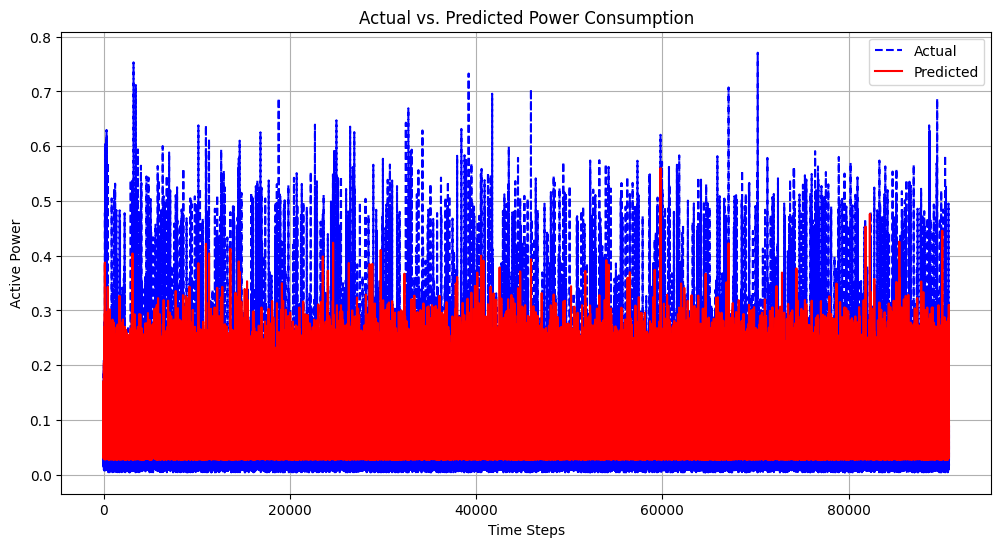

In [19]:
# Plot actual vs. predicted values
plt.figure(figsize=(12, 6))
plt.plot(y_test_original, label="Actual", linestyle='dashed', color='blue')
plt.plot(y_pred_original, label="Predicted", linestyle='solid', color='red')

plt.xlabel("Time Steps")
plt.ylabel("Active Power")
plt.title("Actual vs. Predicted Power Consumption")
plt.legend()
plt.grid()
plt.show()

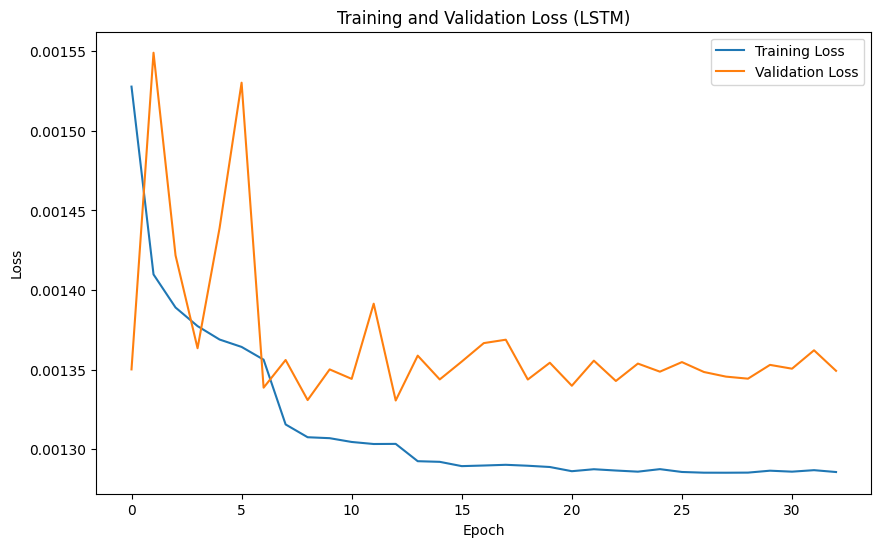

In [20]:
# Plot training loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss (LSTM)')
plt.legend()
plt.show()

In [21]:
features_dim = len(FEATURES)

In [ ]:
# LIME Explanation for the LSTM Model

# Flatten the sequential data from (samples, time_steps, features) to (samples, time_steps*features)
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# Generate feature names for flattened data
feature_names_flat = []
for t in range(time_steps):
    for feature in FEATURES:
        feature_names_flat.append(f"{feature}_t{t+1}")

# Define a wrapper function that reshapes the flat data back to the sequential shape before predicting
def predict_wrapper(flat_data):
    n_samples = flat_data.shape[0]
    reshaped = flat_data.reshape(n_samples, time_steps, features_dim)  # Use features_dim instead of FEATURES
    preds = model_cnn_lstm.predict(reshaped)
    return preds.ravel()  # Return a 1D array

# Create a LimeTabularExplainer for regression
lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train_flat,
    feature_names=feature_names_flat,
    mode='regression'
)

# Explain the prediction for one test instance (using the first instance as an example)
i = 0
exp = lime_explainer.explain_instance(
    data_row=X_test_flat[i],
    predict_fn=predict_wrapper,
    num_features=10  # Adjust to show top contributing features
)

# Display the LIME explanation
try:
    exp.show_in_notebook(show_table=True, show_all=False)
except ImportError:
    from IPython.display import display, HTML
    display(HTML(exp.as_html()))

# Alternatively, print the explanation as text in the console
print("LIME Explanation (Feature Contributions):")
for feature, weight in exp.as_list():
    print(f"{feature}: {weight:.4f}")
    
# Save Lime explanation as HTML
lime_html = exp.as_html()   
with open('exp7_lime_explanation.html', 'w') as f:
    f.write(lime_html)

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


LIME Explanation (Feature Contributions):
apparent_power_t3 <= 0.06: -0.0242
current_t3 <= 0.05: -0.0225
apparent_power_t2 <= 0.06: -0.0186
current_t2 <= 0.05: -0.0180
reactive_power_t2 <= 0.05: 0.0066
current_t1 <= 0.05: 0.0065
year_t3 <= 0.50: 0.0061
apparent_power_t1 <= 0.06: 0.0061
active_power_rolling_mean_t2 <= 0.07: -0.0060
active_power_rolling_mean_t3 <= 0.07: -0.0047


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


  0%|          | 0/10 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
6794/6794 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step


 10%|█         | 1/10 [00:16<02:30, 16.75s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
6794/6794 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step


 20%|██        | 2/10 [00:30<02:01, 15.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
6794/6794 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step


 30%|███       | 3/10 [00:43<01:36, 13.86s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
6794/6794 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step


 40%|████      | 4/10 [00:54<01:17, 12.92s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
6794/6794 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step


 50%|█████     | 5/10 [01:06<01:02, 12.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
6794/6794 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step


 60%|██████    | 6/10 [01:17<00:48, 12.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
6794/6794 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step


 70%|███████   | 7/10 [01:27<00:33, 11.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
6794/6794 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step


 80%|████████  | 8/10 [01:38<00:22, 11.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
6794/6794 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step


 90%|█████████ | 9/10 [01:48<00:10, 10.93s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
6794/6794 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step


100%|██████████| 10/10 [01:58<00:00, 11.87s/it]


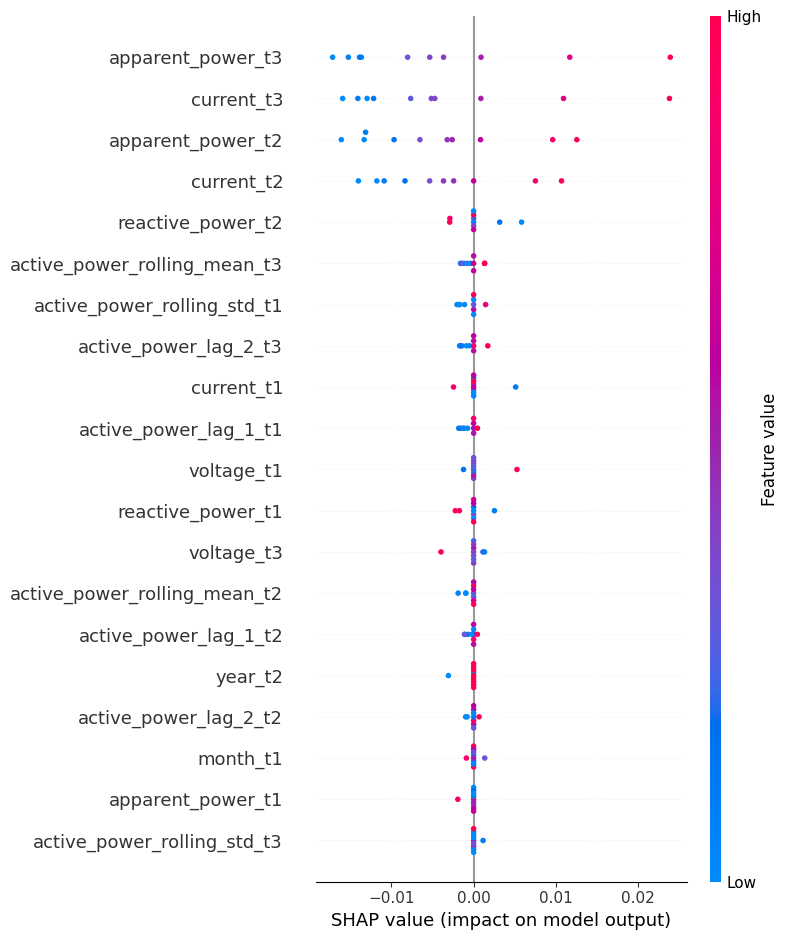

In [23]:
# Define a prediction wrapper
def predict_shap(data):
    # Reshape the flat data back to the original shape (samples, time_steps, features)
    reshaped_data = data.reshape(data.shape[0], time_steps, features_dim)
    return model_cnn_lstm.predict(reshaped_data).flatten()

# Use a subset of X_train for the explainer
explainer = shap.KernelExplainer(predict_shap, X_train[:100].reshape(100, -1))  # Flatten for KernelExplainer

# Calculate SHAP values for a subset of the test data
shap_values = explainer.shap_values(X_test[:10].reshape(10, -1))  # Flatten for KernelExplainer

# Visualize SHAP summary plot
shap.summary_plot(shap_values, X_test[:10].reshape(10, -1), feature_names=feature_names_flat)